## 📝 Project Overview

In this project, I implement and train a **Vision Transformer (ViT)** from scratch for CIFAR-10 image classification using PyTorch.
CIFAR-10 consists of 60 000 RGB images (32×32) belonging to 10 object classes.

I designed and trained the model to explore how transformer-based architectures perform on small-scale vision tasks compared to conventional CNNs. The notebook covers data preparation, model definition, training, evaluation, and visualization of results.


In [1]:
# Import libraries for training

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from einops.layers.torch import Rearrange
from einops import rearrange


from torch.utils.data import DataLoader


## 🧰 Data Preparation

For this project, I use the standard CIFAR-10 training and test splits.
Before feeding the images into the model, I apply several preprocessing steps:

- **Augmentation** (random crops, horizontal flips, AutoAugment) to increase data diversity.
- **Normalization** to standardize pixel intensities and stabilize training.
- **Mini-batch loading** using PyTorch `DataLoader` for efficient iteration.

These steps help improve the model’s generalization and convergence during training.


In [2]:
# Define train/test dataloaders with transforms (augmentation + normalization)

def get_dataloaders(batch_size=256):
    normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std =[0.2470, 0.2435, 0.2616]
    )

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize,
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    full_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


    # Took the full size sets
    trainloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
    testloader = DataLoader(full_test, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)

    return trainloader, testloader

In [3]:

class PatchEmbedding(nn.Module):
    """
    Patch Embedding for Vision Transformers.
    Input:
        x: A 4D tensor of shape (B, C, H, W), where B = batch size, C = channels,
           H = height of image, W = width of image.
    Output:
        A 3D tensor of shape (B, N, emb_size), where N = number of patches (H*W / patch_size^2).
    """

    def __init__(self, in_channels = 3, image_size = 32, patch_size = 8, emb_size = 128):
        super().__init__()

        'assuming square image'
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = in_channels * patch_size * patch_size
        self.projection = nn.Sequential(
            # Rearrange image into a patch sequence
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # Apply a linear layer to project patch to `emb_size`
            nn.Linear(patch_dim, emb_size)
        )

    def forward(self, x) :
        return self.projection(x)


## 🏗 Vision Transformer Design

I implement the Vision Transformer architecture from the ground up, adapted for small CIFAR-10 images.

The architecture includes:
- A **self-attention** mechanism to model patch-to-patch dependencies.
- A **feedforward MLP** applied after attention for feature transformation.
- **Transformer blocks** with residual connections and layer normalization.
- A **classification head** on top of a special class token.

This modular structure follows the core ViT idea: treat image patches as sequence tokens and apply transformer layers for classification.


In [4]:
class Attention(nn.Module):
    def __init__(self, dim, heads=2, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)
        assert dim == heads * dim_head, "dim must be divisible by num_heads"

        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=True)
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3,dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attend = self.attend(dots)
        out = torch.matmul(attend, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)



In [5]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


In [6]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
            Attention(dim, heads, dim_head, dropout),
            FeedForward(dim, mlp_dim, dropout)]
            ))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [7]:
# Combining blocks to create the ViT model

class MyViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (class token) or mean (mean pooling)'
        self.to_patch_embedding = PatchEmbedding(image_size=image_size, patch_size=patch_size, in_channels=channels, emb_size=dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.out = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = self.cls_token.repeat(b, 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        x = self.transformer(x)
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        x = self.out(x)
        return x


In [8]:
trainloader, testloader = get_dataloaders()


100%|██████████| 170M/170M [00:06<00:00, 27.7MB/s]


## ⚙️ Optimization Setup

I configure the training pipeline by defining the optimizer, loss function, and a two-stage learning rate schedule.

- **Loss function:** I use cross-entropy loss, which is standard for multi-class classification problems like CIFAR-10.
- **Optimizer:** I choose AdamW, which combines Adam’s adaptive learning rates with decoupled weight decay, improving generalization compared to plain Adam.
- **Learning rate schedule:** I use a **Linear Warmup + Cosine Annealing** schedule.
  - During the warmup phase, the learning rate increases linearly from a small starting factor to the target value over the first few epochs.
  - After warmup, the Cosine Annealing schedule gradually decreases the learning rate following a cosine curve, helping stabilize convergence and avoid sharp drops in loss late in training.

This combination of warmup and cosine annealing is particularly effective for transformer models, as it allows stable early training while still providing a smooth decay later on.


In [9]:
import torch.optim as optim

model = MyViT(image_size=32, patch_size=4, num_classes=10, dim=384, dim_head=48, heads=8, depth=8, mlp_dim=768, pool='cls', dropout=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 250
lr = 0.0003
weight_decay = 0.1
eta_min = 1e-12
warmup = 10

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/25, end_factor=1.0, total_iters=warmup * len(trainloader))
main_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (num_epochs - warmup) * len(trainloader), eta_min=eta_min)
scheduler = optim.lr_scheduler.SequentialLR(
optimizer,
schedulers = [warmup_scheduler, main_scheduler],
milestones=[10 * len(trainloader)]
)


## 🚀 Training Procedure

I train the model using cross-entropy loss and the Adam optimizer.
Training is performed for multiple epochs, iterating over mini-batches to update parameters and minimize classification error.

I evaluate the model on the test set after each epoch to track generalization performance throughout training.


In [10]:
# Training and evaluation loop for 250 epochs
# Tracks: training loss, training accuracy, test loss, test accuracy

%%time
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)


            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            scheduler.step()


            # Track training loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()



        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluation
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss /= total_test
        test_acc = 100. * correct_test / total_test
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch [1/250] Train Loss: 2.2002, Train Acc: 17.18% | Test Loss: 1.9392, Test Acc: 28.45%
Epoch [2/250] Train Loss: 2.0069, Train Acc: 26.75% | Test Loss: 1.6727, Test Acc: 39.28%
Epoch [3/250] Train Loss: 1.8456, Train Acc: 32.96% | Test Loss: 1.4779, Test Acc: 46.98%
Epoch [4/250] Train Loss: 1.7151, Train Acc: 37.95% | Test Loss: 1.3685, Test Acc: 50.69%
Epoch [5/250] Train Loss: 1.6163, Train Acc: 41.54% | Test Loss: 1.2684, Test Acc: 54.77%
Epoch [6/250] Train Loss: 1.5498, Train Acc: 44.27% | Test Loss: 1.2920, Test Acc: 53.89%
Epoch [7/250] Train Loss: 1.4849, Train Acc: 46.45% | Test Loss: 1.1649, Test Acc: 58.51%
Epoch [8/250] Train Loss: 1.4272, Train Acc: 48.79% | Test Loss: 1.1772, Test Acc: 57.85%
Epoch [9/250] Train Loss: 1.3854, Train Acc: 50.31% | Test Loss: 1.0784, Test Acc: 60.91%


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [10/250] Train Loss: 1.3397, Train Acc: 51.94% | Test Loss: 1.0669, Test Acc: 61.29%
Epoch [11/250] Train Loss: 1.3144, Train Acc: 52.92% | Test Loss: 1.0211, Test Acc: 63.62%
Epoch [12/250] Train Loss: 1.2635, Train Acc: 55.00% | Test Loss: 0.9811, Test Acc: 64.62%
Epoch [13/250] Train Loss: 1.2230, Train Acc: 56.35% | Test Loss: 0.9571, Test Acc: 66.04%
Epoch [14/250] Train Loss: 1.1849, Train Acc: 57.55% | Test Loss: 0.9269, Test Acc: 66.89%
Epoch [15/250] Train Loss: 1.1555, Train Acc: 58.94% | Test Loss: 0.8926, Test Acc: 68.26%
Epoch [16/250] Train Loss: 1.1283, Train Acc: 59.95% | Test Loss: 0.8799, Test Acc: 68.53%
Epoch [17/250] Train Loss: 1.0926, Train Acc: 61.23% | Test Loss: 0.8755, Test Acc: 68.68%
Epoch [18/250] Train Loss: 1.0686, Train Acc: 62.19% | Test Loss: 0.8252, Test Acc: 70.32%
Epoch [19/250] Train Loss: 1.0421, Train Acc: 62.77% | Test Loss: 0.8090, Test Acc: 71.33%
Epoch [20/250] Train Loss: 1.0270, Train Acc: 63.64% | Test Loss: 0.7799, Test Acc: 72.19%

## 🧪 Evaluation

After training, I run inference on test images to assess the model’s qualitative performance.
Inspecting predictions visually helps me verify whether the network learned meaningful representations and identify common failure cases between similar classes.


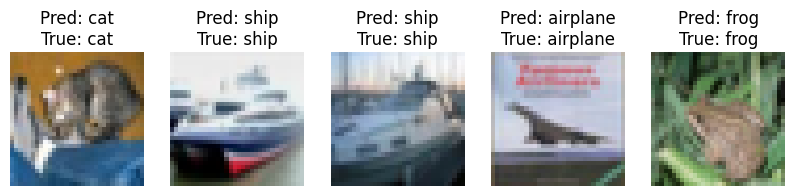

In [11]:
# 🔍 Run inference on a few test images to visualize predictions
import matplotlib.pyplot as plt

classes = trainloader.dataset.classes
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move model to eval mode
model.eval()
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show predictions
fig = plt.figure(figsize=(10,4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    img = images[i].cpu().permute(1, 2, 0)
    img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])  # unnormalize
    ax.imshow(img.clip(0,1))
    ax.set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis('off')


## 🧮 Model Complexity

I calculate the total number of trainable parameters to understand the model’s capacity.
ViTs typically have more parameters than small CNNs, which affects training time and memory usage.


In [12]:
# Calculate Model Parameters

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"~{total_params / 1e6:.2f} million parameters")


Total parameters: 9,519,754
~9.52 million parameters


## 📊 Training Results

After completing the training, I plot the accuracy and loss curves recorded over all epochs.
These plots give a clear overview of how the model’s performance evolved during training:

- They show how quickly and steadily the network learned.
- They reveal potential issues like overfitting (diverging train/test curves) or underfitting (both curves plateauing at low performance).
- They help me evaluate whether the chosen optimization strategy and architecture were effective.

Visualizing the full training history makes it easier to interpret the final results and diagnose any training instabilities.


# 📈 Plot: Test Accuracy vs Epochs


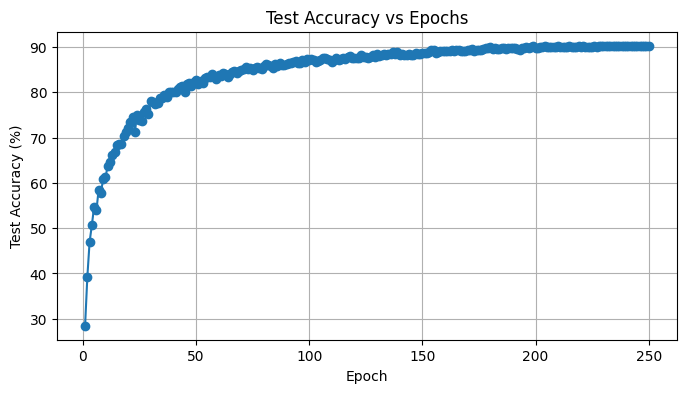

In [13]:
import matplotlib.pyplot as plt
def plot_test_acc():
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs+1), test_accs, marker='o')
    plt.title("Test Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True)
    plt.show()
plot_test_acc()

# 📉 Plot: Training and Test Loss vs Epochs


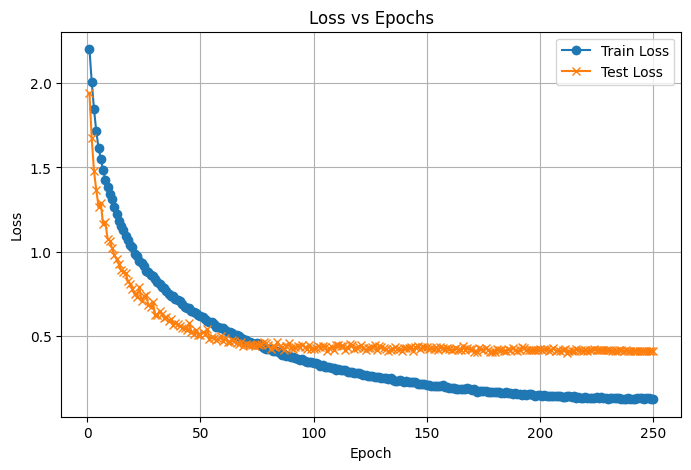

In [14]:
# Plot Train and Test Loss
def plot_train_test_loss():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_train_test_loss()

## ✅ Summary & Takeaways

This project demonstrates how I designed and trained a **Vision Transformer (ViT)** from scratch for CIFAR-10 image classification, achieving a test accuracy of over 90% after 250 epochs.

**Techniques used:**
- Custom Vision Transformer architecture with multi-head self-attention
- Data augmentation and normalization for better generalization
- AdamW optimizer with weight decay
- Linear warmup followed by Cosine Annealing learning rate scheduling

The model shows that transformer-based architectures can perform competitively on small-scale image classification tasks when trained with proper optimization strategies.
Further improvements could include stronger regularization, model scaling, or pretraining on larger datasets before fine-tuning on CIFAR-10.
